# Exploratory data analysis 1

This notebook demonstrates that the ground truth turning angles tend to have more extreme values with higher speeds and with manual driving.

In [1]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [51]:
from matplotlib import pyplot as plt

def plot_all(name, ground_truths):
    plt.figure()
    hist, bins, _ = plt.hist(ground_truths.values(), bins=15, density=True, stacked=False)
    plt.title(name)
    plt.legend(ground_truths.keys())
    plt.xlabel('angle')
    plt.ylabel('density')
    plt.xticks([-1, 0, 1], ['-1 (left)', '0 (center)', '1 (right)'])
    plt.grid()
    plt.show()
    return hist

In [52]:
import numpy as np

fast_manual_gt = np.load('open-loop-results/daytime-manual-fast-3d-model-daytime-fast-data-prediction-and-ground-truth.npy')[:, 2]
slow_manual_gt = np.load('open-loop-results/daytime-manual-slow-3d-model-daytime-slow-data-prediction-and-ground-truth.npy')[:, 2]

fast_auto_gt = np.load('open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')[:, 2]
slow_auto_gt = np.load('open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')[:, 2]

np.concatenate((fast_manual_gt, slow_manual_gt)).shape, np.concatenate((fast_auto_gt, slow_auto_gt)).shape

((52132,), (39554,))

## Demonstrate that fast driving has more extreme ground truth turning angles


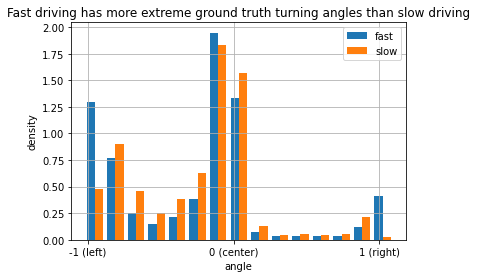

In [54]:

hist = plot_all('Fast driving has more extreme ground truth turning angles than slow driving', dict(fast=fast_auto_gt, slow=slow_auto_gt))


## Demonstrate that manual driving has more extreme ground truth turning angles

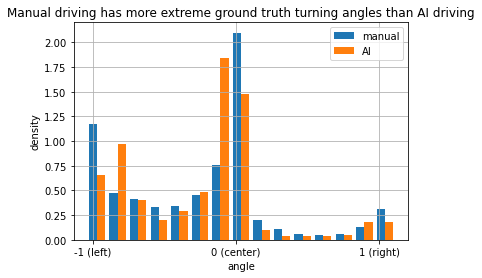

In [53]:

hist = plot_all('Manual driving has more extreme ground truth turning angles than AI driving', dict(
    manual=np.concatenate((fast_manual_gt, slow_manual_gt)),
    AI=np.concatenate((fast_auto_gt, slow_auto_gt))))